In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import qkeras
from qkeras import *
from skimage.measure import block_reduce

2023-10-31 00:57:04.987302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/nevis/westside/data/sc5303/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
# Parameters
params = {'dim': (32,32,32),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)

In [2]:
# Open the HDF5 file
file_path = '/nevis/westside/data/sc5303/Data/bnb_WithWire_16.h5'
ntimeticks = 6400
nwire = 3456

with h5py.File(file_path, 'r') as hf:
    # Access the "wire_table" group
    wire_table_group = hf['wire_table']
    startEvt = 0
    endEvt = 1
    nEvt = endEvt - startEvt
    # Define the start and end indices for the subset you want to load

    # Load the subsets of the data using slicing and convert them to DataFrames
    event_ids = [wire_table_group['event_id'][Evt*8256] for Evt in range(startEvt, endEvt)]
    planeadcs = [wire_table_group['adc'][4800+Evt*8256:8256+Evt*8256] for Evt in range(startEvt, endEvt)]

    nplanes=len(planeadcs)


    f_downsample = 1
    for p in range(0,nplanes):
        planeadcs[p] = block_reduce(planeadcs[p], block_size=(1,f_downsample), func=np.sum)

    adccutoff = 10.*f_downsample/10.
    adcsaturation = 100.*f_downsample/10.
    for p in range(0,nplanes):
        planeadcs[p][planeadcs[p]<adccutoff] = 0
        planeadcs[p][planeadcs[p]>adcsaturation] = adcsaturation


In [5]:
planeadcs

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

In [3]:
f_split = 1
X = np.array(np.split(np.array(planeadcs), f_split, axis=2))
X = np.reshape(X, (-1,nwire,ntimeticks//f_downsample//f_split,1))
print('X      shape: ' + str(X.shape))

full_split = 1
full = np.array(np.split(np.array(planeadcs), full_split, axis=2))
full = np.reshape(full, (-1,nwire,ntimeticks//f_downsample//full_split,1))
print('full      shape: ' + str(full.shape))

X      shape: (1, 3456, 6400, 1)
full      shape: (1, 3456, 6400, 1)


In [4]:
train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio

# Create an array of original indices
original_indices = np.arange(X.shape[0])

# Perform the train/test split
X_train_val_indices, X_test_indices = train_test_split(original_indices, test_size=test_ratio, random_state=42)
X_train_indices, X_val_indices = train_test_split(X_train_val_indices, test_size=val_ratio / (val_ratio + train_ratio), random_state=42)
del X_train_val_indices
# Use the indices to access the corresponding data
X_test = X[X_test_indices]
X_train = X[X_train_indices]
X_val = X[X_val_indices]

# X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 42)
# X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)
# del X_train_val

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))


X_train shape: (499, 3456, 64, 1)
X_val   shape: (101, 3456, 64, 1)
X_test  shape: (400, 3456, 64, 1)


In [4]:
encoder_input = tf.keras.Input(shape=(nwire,ntimeticks//f_downsample//f_split,1), name='input')

encoder = layers.Conv2D(20, (3,3), strides=1, padding='same', name='conv2d_1')(encoder_input)
encoder = layers.Activation('relu', name='relu_1')(encoder)
encoder = layers.AveragePooling2D((2,2), name='pool_1')(encoder)
encoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_2')(encoder)
encoder = layers.Activation('relu', name='relu_2')(encoder)
encoder = layers.Flatten(name='flatten')(encoder)

encoder_output = layers.Dense(80, activation='relu', name='latent')(encoder)

encoder = tf.keras.models.Model(encoder_input, encoder_output)

decoder = layers.Dense(nwire//2*ntimeticks//f_downsample//f_split//2*30, name='dense')(encoder_output)
decoder = layers.Reshape((nwire//2,ntimeticks//f_downsample//f_split//2,30), name='reshape2')(decoder)
decoder = layers.Activation('relu', name='relu_3')(decoder)
decoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_3')(decoder)
decoder = layers.Activation('relu', name='relu_4')(decoder)
decoder = layers.UpSampling2D((2,2), name='upsampling')(decoder)
decoder = layers.Conv2D(20, (3,3), strides=1, padding='same', name='conv2d_4')(decoder)
decoder = layers.Activation('relu', name='relu_5')(decoder)

decoder_output = layers.Conv2D(1, (3,3), activation='relu', strides=1, padding='same', name='output')(decoder)

teacher = tf.keras.Model(encoder_input, decoder_output)

teacher.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'mse')

2023-10-31 00:58:42.189105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 00:58:47.975033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11445 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:01:00.0, compute capability: 6.1
2023-10-31 00:58:47.975381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11445 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1
2023-10-31 00:58:58.679178: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memo

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[165888000,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [6]:
history = teacher.fit(X_train, X_train,
                      epochs = 40,
                      validation_data = (X_val, X_val),
                      batch_size = 32)

Epoch 1/40


2023-10-29 14:18:00.609362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-10-29 14:18:00.944945: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-29 14:18:03.475980: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4bef6a6f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 14:18:03.475999: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-10-29 14:18:03.476003: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-10-29 14:18:03.479402: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 14:18:03.536859: I tensorflow/tsl/platform

16/16 [==============================] - 15s 487ms/step - loss: 18.0606 - val_loss: 19.2463
Epoch 2/40
16/16 [==============================] - 4s 245ms/step - loss: 17.9539 - val_loss: 19.2232
Epoch 3/40
16/16 [==============================] - 4s 245ms/step - loss: 17.7256 - val_loss: 19.2180
Epoch 4/40
16/16 [==============================] - 4s 244ms/step - loss: 17.0751 - val_loss: 19.2158
Epoch 5/40
16/16 [==============================] - 4s 245ms/step - loss: 16.3201 - val_loss: 19.2179
Epoch 6/40
16/16 [==============================] - 4s 244ms/step - loss: 15.2538 - val_loss: 19.2122
Epoch 7/40
16/16 [==============================] - 4s 245ms/step - loss: 14.5765 - val_loss: 19.2110
Epoch 8/40
16/16 [==============================] - 4s 244ms/step - loss: 13.7635 - val_loss: 19.2329
Epoch 9/40
16/16 [==============================] - 4s 244ms/step - loss: 12.9030 - val_loss: 19.2306
Epoch 10/40
16/16 [==============================] - 4s 245ms/step - loss: 11.3765 - val_los

In [7]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

X_train_predict_teacher = teacher.predict(X_train)
X_val_predict_teacher = teacher.predict(X_val)
X_test_predict_teacher = teacher.predict(X_test)
X_predict_teacher = teacher.predict(X)

X_train_loss_teacher = loss(X_train, X_train_predict_teacher, 'mse')
X_val_loss_teacher = loss(X_val, X_val_predict_teacher, 'mse')
X_test_loss_teacher = loss(X_test, X_test_predict_teacher, 'mse')
X_loss_teacher = loss(X, X_predict_teacher, 'mse')

 3/16 [====>.........................] - ETA: 0s

2023-10-29 14:20:51.691161: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-29 14:20:51.691200: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


12/13 [==========================>...] - ETA: 0s

2023-10-29 14:20:54.828099: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-29 14:20:54.828134: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 3s 80ms/step


In [8]:
# v2
x_in = layers.Input(shape=(nwire*ntimeticks//f_downsample//f_split,), name="In")
x = layers.Reshape((nwire,ntimeticks//f_downsample//f_split,1), name='reshape')(x_in)

x = QConv2D(3,(3,3), strides=2, padding="valid", use_bias=False,
            kernel_quantizer=quantized_bits(16,4,1,alpha='auto'), name='conv')(x)
x = QActivation('quantized_relu(16,4)', name='relu1')(x)
x = layers.Flatten(name='flatten')(x)
x = QDense(20, kernel_quantizer=quantized_bits(16,4,1,alpha='auto'),
           use_bias=False, name='dense1')(x)
x = QActivation('quantized_relu(16,4)', name='relu2')(x)
x = QDense(1, kernel_quantizer=quantized_bits(16,2,1,alpha='auto'),
           use_bias=False, name='output')(x)

student = tf.keras.models.Model(x_in, x)
student.summary()
student.compile(optimizer = 'adam', loss = 'mse')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 In (InputLayer)             [(None, 221184)]          0         
                                                                 
 reshape (Reshape)           (None, 3456, 64, 1)       0         
                                                                 
 conv (QConv2D)              (None, 1727, 31, 3)       27        
                                                                 
 relu1 (QActivation)         (None, 1727, 31, 3)       0         
                                                                 
 flatten (Flatten)           (None, 160611)            0         
                                                        

In [9]:
history = student.fit(X_train.reshape((-1,nwire*ntimeticks//f_downsample//f_split,1)), X_train_loss_teacher,
                      epochs = 30,
                      validation_data = (X_val.reshape((-1,nwire*ntimeticks//f_downsample//f_split,1)), X_val_loss_teacher),
                      batch_size = 128)

Epoch 1/30


2023-10-29 14:21:07.460274: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model_2/relu1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 2s 233ms/step - loss: 83.2529 - val_loss: 488.1922
Epoch 2/30
4/4 [==============================] - 0s 56ms/step - loss: 99.6677 - val_loss: 510.9138
Epoch 3/30
4/4 [==============================] - 0s 56ms/step - loss: 63.1147 - val_loss: 513.4410
Epoch 4/30
4/4 [==============================] - 0s 55ms/step - loss: 55.8129 - val_loss: 513.5953
Epoch 5/30
4/4 [==============================] - 0s 55ms/step - loss: 51.8174 - val_loss: 513.7795
Epoch 6/30
4/4 [==============================] - 0s 55ms/step - loss: 47.8023 - val_loss: 513.8868
Epoch 7/30
4/4 [==============================] - 0s 57ms/step - loss: 43.6794 - val_loss: 513.8239
Epoch 8/30
4/4 [==============================] - 0s 56ms/step - loss: 40.3855 - val_loss: 513.6555
Epoch 9/30
4/4 [==============================] - 0s 55ms/step - loss: 37.9685 - val_loss: 513.3581
Epoch 10/30
4/4 [==============================] - 0s 58ms/step - loss: 36.8780 - val_loss: 512.2934
Epoch 11/

In [10]:
X_train_loss_student = student.predict(X_train.reshape((-1,nwire*ntimeticks//f_downsample//f_split,1)))
X_val_loss_student = student.predict(X_val.reshape((-1,nwire*ntimeticks//f_downsample//f_split,1)))
X_test_loss_student = student.predict(X_test.reshape((-1,nwire*ntimeticks//f_downsample//f_split,1)))
X_loss_student = student.predict(X.reshape((-1,nwire*ntimeticks//f_downsample//f_split,1)))

32/32 [==============================] - 0s 9ms/step


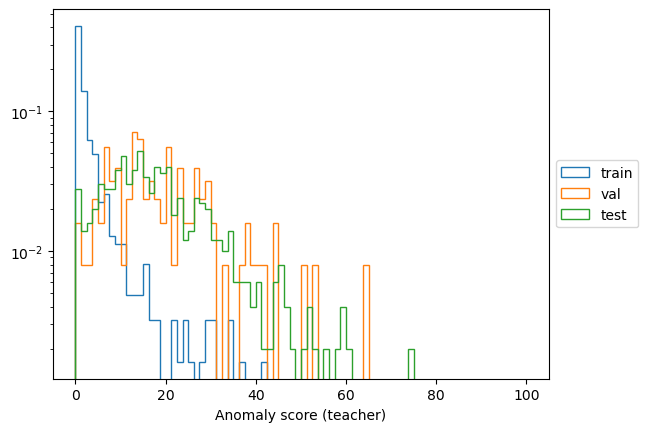

In [11]:
nbins = 80
rmin = 0
rmax = 100
plt.hist(X_train_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'train', range = (rmin, rmax), log = True, histtype='step')
plt.hist(X_val_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'val', range = (rmin, rmax), log = True, histtype='step')
plt.hist(X_test_loss_teacher, density = 1, bins = nbins, alpha = 1, label = 'test', range = (rmin, rmax), log = True, histtype='step')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Anomaly score (teacher)")
plt.show()

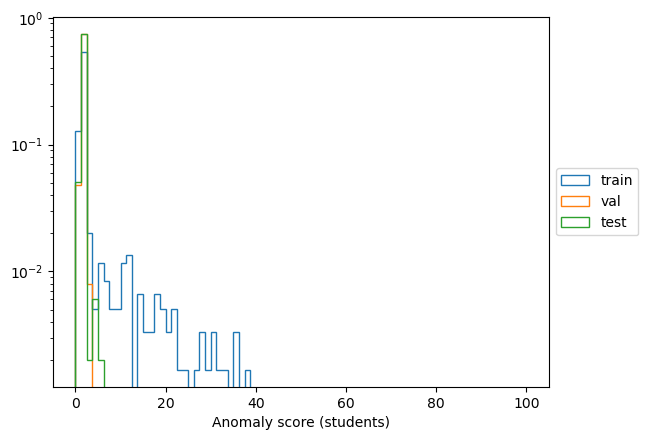

In [12]:
nbins = 80
rmin = 0
rmax = 100
plt.hist(X_train_loss_student, density = 1, bins = nbins, alpha = 1, label = 'train', range = (rmin, rmax), log = True, histtype='step')
plt.hist(X_val_loss_student, density = 1, bins = nbins, alpha = 1, label = 'val', range = (rmin, rmax), log = True, histtype='step')
plt.hist(X_test_loss_student, density = 1, bins = nbins, alpha = 1, label = 'test', range = (rmin, rmax), log = True, histtype='step')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Anomaly score (students)")
plt.show()

In [15]:
# Use boolean indexing to get the indices of values over the threshold
indices = np.where(X_loss_teacher > 50)

# Convert the indices to a list (if needed)
indices_list = indices[0].tolist()

zmax = adcsaturation

# Turn off interactive plotting
plt.ioff()

for evt in indices_list:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
    true_indice = evt
    
    # Transpose the image
    transposed_image = full[true_indice%nEvt][:, :, 0].T

    im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
    ax1.set_title(f"Plane 2 run{event_ids[true_indice%nEvt][0]}, subrun{event_ids[true_indice%nEvt][1]}, event{event_ids[true_indice%nEvt][2]}, anomaly score: {X_loss_teacher[true_indice]:.2f} (teacher), {X_loss_student[true_indice][0]:.2f} (student)")
    ax1.set_xlabel("Wire")
    ax1.set_ylabel("Time Tick")
    ax1.axhline((true_indice//nEvt)*64, linewidth=0.5, color='yellow', ls='-')
    ax1.axhline((true_indice//nEvt+1)*64, linewidth=0.5, color='yellow', ls='-')

    # Save the figure without displaying it
    fig.savefig(f'output/strips64/full/{event_ids[true_indice%nEvt]}.png')
    # Close the figure to release resources
    plt.close(fig)

# Turn interactive plotting back on
plt.ion()

/tmp/ipykernel_40578/310815403.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title(f"Plane 2 run{event_ids[true_indice%nEvt][0]}, subrun{event_ids[true_indice%nEvt][1]}, event{event_ids[true_indice%nEvt][2]}, anomaly score: {X_loss_teacher[true_indice]:.2f} (teacher), {float(X_loss_student[true_indice]):.2f} (student)")


In [31]:
# Use boolean indexing to get the indices of values over the threshold
indices = np.where(X_loss_student > 30)

# Convert the indices to a list (if needed)
indices_list = indices[0].tolist()

zmax = adcsaturation

# Turn off interactive plotting
plt.ioff()

for evt in indices_list:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
    true_indice = evt
    
    # Transpose the image
    transposed_image = full[true_indice%nEvt][:, :, 0].T

    im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
    ax1.set_title(f"Plane 2 run{event_ids[true_indice%nEvt][0]}, subrun{event_ids[true_indice%nEvt][1]}, event{event_ids[true_indice%nEvt][2]}, anomaly score: {X_loss_teacher[true_indice]:.2f} (teacher), {X_loss_student[true_indice][0]:.2f} (student)")
    ax1.set_xlabel("Wire")
    ax1.set_ylabel("Time Tick")
    ax1.axhline((true_indice//nEvt)*64, linewidth=0.5, color='yellow', ls='-')
    ax1.axhline((true_indice//nEvt+1)*64, linewidth=0.5, color='yellow', ls='-')

    # Save the figure without displaying it
    fig.savefig(f'output/strips64/student/{event_ids[true_indice%nEvt]}.png')
    # Close the figure to release resources
    plt.close(fig)

# Turn interactive plotting back on
plt.ion()

KeyboardInterrupt: 

In [13]:
teacher.save('/nevis/westside/data/sc5303/saved_models/teacher_slices64')
student.save('/nevis/westside/data/sc5303/saved_models/student_slices64')

INFO:tensorflow:Assets written to: /nevis/westside/data/sc5303/saved_models/teacher_slices64/assets


INFO:tensorflow:Assets written to: /nevis/westside/data/sc5303/saved_models/teacher_slices64/assets


INFO:tensorflow:Assets written to: /nevis/westside/data/sc5303/saved_models/student_slices64/assets


INFO:tensorflow:Assets written to: /nevis/westside/data/sc5303/saved_models/student_slices64/assets


In [ ]:
teacher = tf.keras.models.load_model('saved_models/teacher2023_aug1')
teacher.summary()
tf.get_logger().setLevel('ERROR')
#student = qkeras.utils.load_qmodel('saved_models/student2023_aug1_v1') # 2023 v1
student = qkeras.utils.load_qmodel('saved_models/student2023_aug1_v2') # 2023 v2
student.summary()
student.get_config()